## Length of the code {-}
No restriction

<span style="color: red;">*Note: Any AI tools used must be disclosed in the final report.*</span>

**Delete this section from the report, when using this template.** 

## Import necessary packages

In [1]:
# load in packages
import pandas as pd
import numpy as np
from shapely import wkt
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import seaborn as sns

## Data quality check / cleaning / preparation 

Put code with comments. The comments should explain the code such that it can be easily understood. You may put text *(in a markdown cell)* before a large chunk of code to explain the overall purpose of the code, if it is not intuitive. **Put the name of the person / persons who contributed to each code chunk / set of code chunks.** An example is given below.

### Q1.

### Q2.

### Q3. 

### Q4. Mobility and Safety Datasets
*By Isabella Yan (Chisa)*

Question: How do traffic crashes, adult physical inactivity, and Divvy station accessibility relate across Chicago’s community areas, and do neighborhoods with higher physical inactivity experience different crash rates or different access to bike-share infrastructure?

#### Step 1: Clean up data

In [2]:
#
# 1.1. load data from healthdatasets
#
community_boundary_data = pd.read_csv('./datasets/healthdatasets/Boundaries_-_Community_Areas_20251201.csv')
divvy_data = pd.read_csv('./datasets/healthdatasets/202412-divvy-tripdata.csv')
health_data = pd.read_csv('./datasets/healthdatasets/2024chicagohealthatlas_raw.csv')

#
# 1.2. Clean community area boundaries
#

# rename columns
community_boundary_data = community_boundary_data.rename(columns={
    'AREA_NUMBE': 'community_area_number',
    'COMMUNITY': 'community_area_name',
    'AREA_NUM_1': 'community_area_number_dup',
    'the_geom': 'wkt_geometry',
    'SHAPE_AREA': 'shape_area',
    'SHAPE_LEN': 'shape_length'
})

# standardize community name 
community_boundary_data['community_area_name'] = (
    community_boundary_data['community_area_name'].str.title()
)

# use wkt from shapely to convert the wkt to geometry
community_boundary_data['geometry'] = community_boundary_data['wkt_geometry'].apply(wkt.loads)

# convert to geopanda dataframe 
community_boundary_data = gpd.GeoDataFrame(
    community_boundary_data,
    geometry='geometry',
    crs="EPSG:4326"
)

# extract centroids (useful for lat/lon)
# reproject to Illinois StatePlane (good for Chicago)
boundary_projected = community_boundary_data.to_crs(epsg=3435)

# compute centroids in that CRS
centroids = boundary_projected.centroid

# convert centroids back to WGS84 (lat/lon)
centroids_wgs = centroids.to_crs(epsg=4326)

# store results
community_boundary_data['centroid_lat'] = centroids_wgs.y
community_boundary_data['centroid_lon'] = centroids_wgs.x

#
# 1.3. Clean divvy data
#

# convert all timestamps to datetime objects 
divvy_data['started_at'] = pd.to_datetime(divvy_data['started_at'])
divvy_data['ended_at'] = pd.to_datetime(divvy_data['ended_at'])

# remove invalid rides
divvy_data = divvy_data[
    (divvy_data['ended_at'] > divvy_data['started_at']) &
    (divvy_data['start_lat'].notna()) &
    (divvy_data['start_lng'].notna())
]

# create duration + data features
divvy_data['ride_minutes'] = (divvy_data['ended_at'] - divvy_data['started_at']).dt.total_seconds() / 60
divvy_data['date'] = divvy_data['started_at'].dt.date
divvy_data['hour'] = divvy_data['started_at'].dt.hour
divvy_data['day_of_week'] = divvy_data['started_at'].dt.day_name()

# connect divvy start and end points to lat and lon 
divvy_data['start_point'] = divvy_data.apply(lambda r: Point(r['start_lng'], r['start_lat']), axis=1)
divvy_data['end_point'] = divvy_data.apply(lambda r: Point(r['end_lng'], r['end_lat']), axis=1)


#
# 1.4. Clean health data 
#

# drop metadata rows
health_data = health_data.iloc[4:].reset_index(drop=True)

# rename columns to understand them    
health_data = health_data.rename(columns={
    'Name': 'community_area_name',
    'GEOID': 'community_area_number',
    'HCSPAP_2023-2024': 'physical_inactivity_rate',
    'HCSPAP_2023-2024_moe': 'physical_inactivity_rate_moe',
    'HCSPA_2023-2024': 'physical_inactivity_count',
    'HCSPA_2023-2024_moe': 'physical_inactivity_count_moe',
    'TRC_2024': 'traffic_crashes',
    'TRC_2024_moe': 'traffic_crashes_moe'
})

# standardize the names
health_data['community_area_name'] = (
    health_data['community_area_name'].str.title()
)

# convert geoid to int 
health_data['community_area_number'] = (
    health_data['community_area_number'].astype(int)
)

# drop the layer col
health_data = health_data.drop(columns=['Layer'])


#### Step 2: Convert Divvy start points to GeoDataframe, assign to community areas for counts

In [3]:
#
# 2.1. Convert Divvy start points into the geoframe 
#
community_boundary_data = community_boundary_data.to_crs(epsg=3435)

# Convert Divvy points to the same CRS
divvy_gdf = gpd.GeoDataFrame(
    divvy_data,
    geometry=divvy_data['start_point'],
    crs="EPSG:4326"
).to_crs(epsg=3435)

# 
# 2.2. Assign each ride's starting neighborhood  
#
divvy_with_area = gpd.sjoin(
    divvy_gdf,
    community_boundary_data[['community_area_number', 'community_area_name', 'geometry']],
    how='left',
    predicate='within'
)


### Step 3: Get Divvy station counts to measure accessibility per neighborhood. 

In [4]:
#
# 3.1. Identify only unique stations
#
unique_stations = divvy_with_area[
    ['start_station_name', 'community_area_number', 'community_area_name', 'geometry']
].drop_duplicates()

#
# 3.2. Count stations per neighborhood. 
#
station_density = (
    unique_stations
    .groupby('community_area_number')
    .size()
    .reset_index(name='divvy_station_count')
)

#### Step 4: Aggregate Divvy rides and statistics per community area

In [5]:
#
# 4.1. Aggregate Divvy ride volume per community area
#
rides_per_area = (
    divvy_with_area
    .groupby('community_area_number')
    .size()
    .reset_index(name='total_rides_starting_here')
)

#
# 4.2 Merge all Divvy aggregations together
#
divvy_summary = station_density.merge(
    rides_per_area,
    on='community_area_number',
    how='left'
)

#
# 4.3. Merge Divvy summary with health data
#
community_stats = health_data.merge(
    divvy_summary,
    on='community_area_number',
    how='left'
)

community_stats = community_stats.merge(
    community_boundary_data[['community_area_number', 'geometry', 'centroid_lat', 'centroid_lon']],
    on='community_area_number',
    how='left'
)

## Exploratory data analysis

Put code with comments. The comments should explain the code such that it can be easily understood. You may put text *(in a markdown cell)* before a large chunk of code to explain the overall purpose of the code, if it is not intuitive. **Put the name of the person / persons who contributed to each code chunk / set of code chunks.**

### Analysis 1
*By \<Name of person doing the analysis>*

### Analysis 2
*By \<Name of person doing the analysis>*

### Analysis 3
*By \<Name of person doing the analysis>*

### Analysis 4
*By Isabella Yan (Chisa)*

#### Step 1: Check distribution of data and log transform to avoid right skewedness

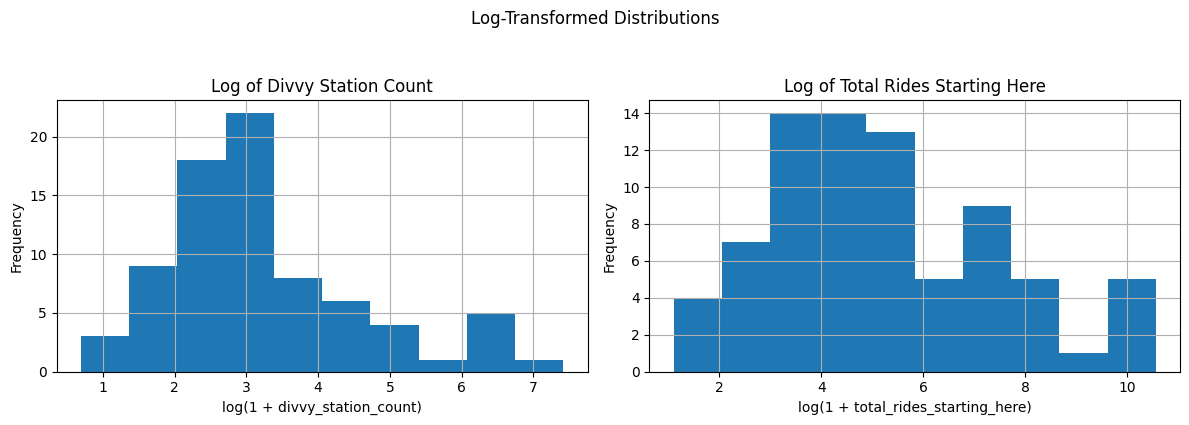

In [6]:
#
# 1.1. Check distribution of data
#

cols = [
    'physical_inactivity_rate',
    'traffic_crashes',
    'divvy_station_count',
    'total_rides_starting_here'
]

# Log-transformed histograms (for skewed variables)
log_cols = ['divvy_station_count', 'total_rides_starting_here']

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Compute log-transformed data
log_data = community_stats[log_cols].apply(np.log1p)

# Plot histograms
log_data.hist(ax=axes)

# Add titles and axis labels
axes[0].set_title("Log of Divvy Station Count")
axes[0].set_xlabel("log(1 + divvy_station_count)")
axes[0].set_ylabel("Frequency")

axes[1].set_title("Log of Total Rides Starting Here")
axes[1].set_xlabel("log(1 + total_rides_starting_here)")
axes[1].set_ylabel("Frequency")

fig.suptitle("Log-Transformed Distributions", y=1.05)

plt.tight_layout()
plt.show()


#### Step 2: Observe correlations between key variables

In [7]:
#
# 2.1. Look at correlations
#
community_stats[['physical_inactivity_rate',
                 'traffic_crashes',
                 'divvy_station_count',
                 'total_rides_starting_here']].corr()


,physical_inactivity_rate,traffic_crashes,divvy_station_count,total_rides_starting_here
physical_inactivity_rate,1.000000,-0.177478,-0.468223,-0.490147
traffic_crashes,-0.177478,1.000000,0.643516,0.670118
divvy_station_count,-0.468223,0.643516,1.000000,0.974841
total_rides_starting_here,-0.490147,0.670118,0.974841,1.000000


#### Step 3: Use scatterplots to visualize relationships between variables

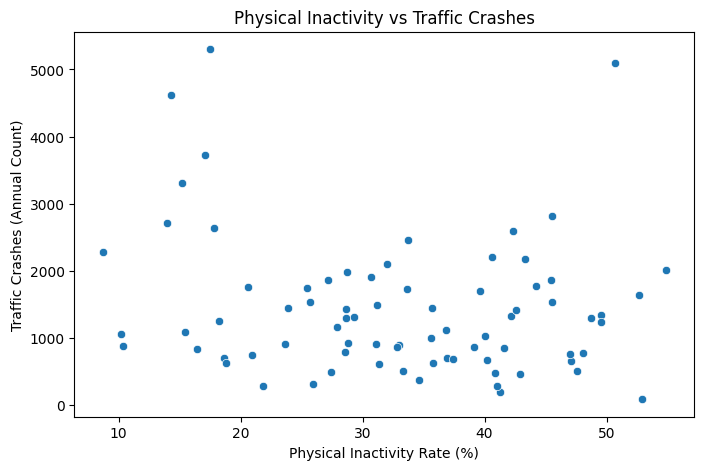

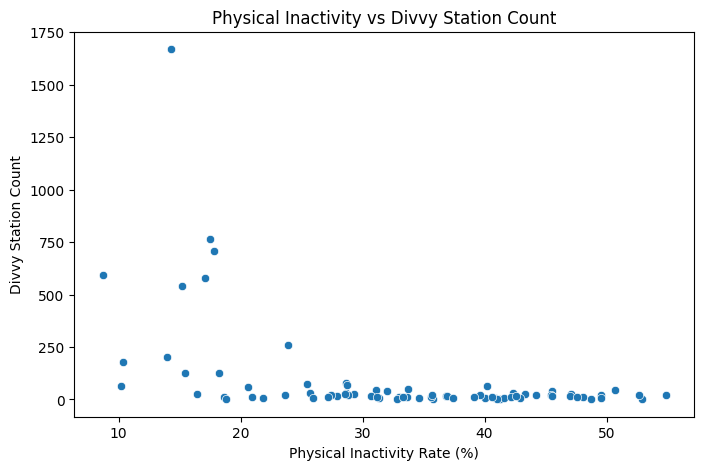

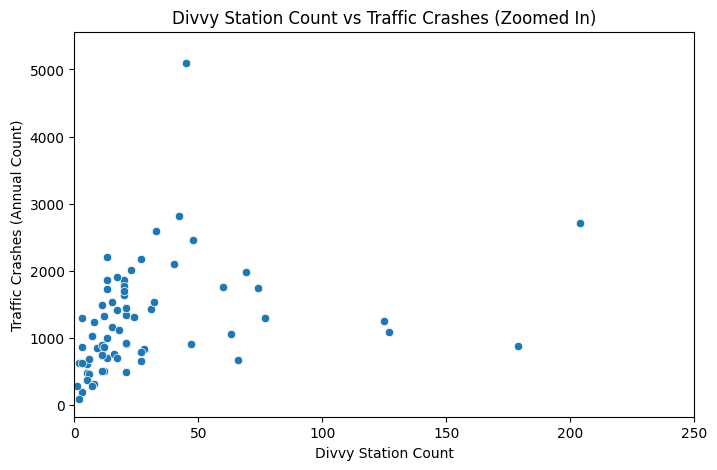

In [8]:
#
# 3.1. Use scatterplots to visualize relationships
#

# convert to numeric values
community_stats['physical_inactivity_rate'] = pd.to_numeric(
    community_stats['physical_inactivity_rate'], errors='coerce'
)

community_stats['traffic_crashes'] = pd.to_numeric(
    community_stats['traffic_crashes'], errors='coerce'
)

community_stats['divvy_station_count'] = pd.to_numeric(
    community_stats['divvy_station_count'], errors='coerce'
)

# Physical inactivity vs traffic crashes
plt.figure(figsize=(8,5))
sns.scatterplot(
    data=community_stats,
    x='physical_inactivity_rate',
    y='traffic_crashes'
)
plt.xlabel("Physical Inactivity Rate (%)")
plt.ylabel("Traffic Crashes (Annual Count)")
plt.title("Physical Inactivity vs Traffic Crashes")
plt.show()

# Physical inactivity vs Divvy station count
plt.figure(figsize=(8,5))
sns.scatterplot(
    data=community_stats,
    x='physical_inactivity_rate',
    y='divvy_station_count'
)
plt.xlabel("Physical Inactivity Rate (%)")
plt.ylabel("Divvy Station Count")
plt.title("Physical Inactivity vs Divvy Station Count")
plt.show()

# Divvy station count vs traffic crashes (zoomed)
plt.figure(figsize=(8,5))
sns.scatterplot(
    data=community_stats,
    x='divvy_station_count',
    y='traffic_crashes'
)
plt.xlim(0, 250)   # zoom for better visibility
plt.xlabel("Divvy Station Count")
plt.ylabel("Traffic Crashes (Annual Count)")
plt.title("Divvy Station Count vs Traffic Crashes (Zoomed In)")
plt.show()

#### Step 4: Craete choropleths to visualize key variable distribution in the context of Chicago community areas

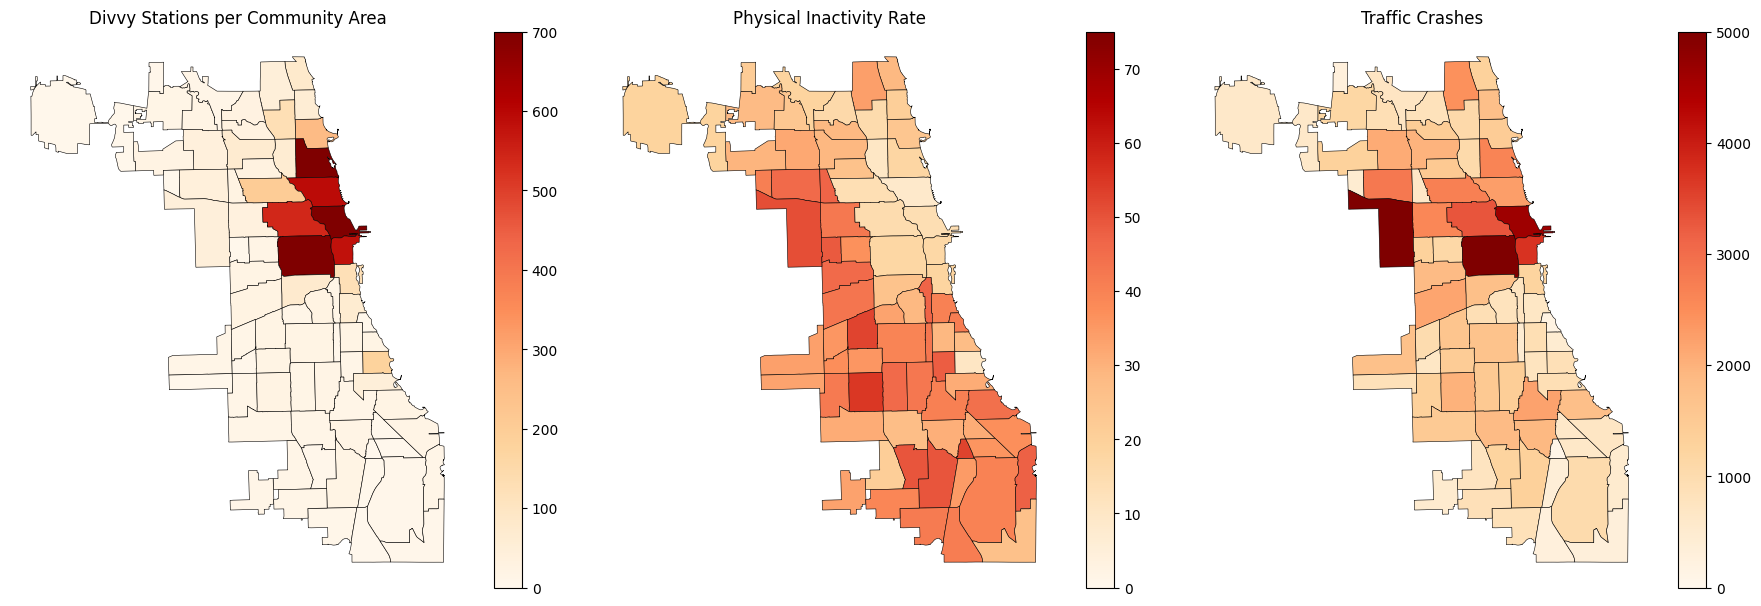

In [9]:
#
# 5.4 Create maps with key variables
#
import geopandas as gpd
from shapely import wkt
import matplotlib.pyplot as plt

# convert WKT geometry column to shapely
community_boundary_data["geometry"] = community_boundary_data["wkt_geometry"].apply(wkt.loads)

gdf = gpd.GeoDataFrame(
    community_boundary_data,
    geometry="geometry",
    crs="EPSG:4326"
)

gdf["community_area_number"] = gdf["community_area_number"].astype(int)
community_stats["community_area_number"] = community_stats["community_area_number"].astype(int)

# merge 
gdf_merged = gdf.merge(community_stats, on="community_area_number", how="left")

# boundary geometry becomes geometry_x
gdf_merged = gdf_merged.set_geometry("geometry_x")

# remove centroid geometry from stats
if "geometry_y" in gdf_merged.columns:
    gdf_merged = gdf_merged.drop(columns=["geometry_y"])

# 3 variables we want to map 
columns_to_map = [
    ("divvy_station_count", "Divvy Stations per Community Area", 0, 700),
    ("physical_inactivity_rate", "Physical Inactivity Rate", 0, 75),
    ("traffic_crashes", "Traffic Crashes", 0, 5000),
]

# set up 3 plots 
fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # 1 row, 3 columns

for ax, (col, title, vmin, vmax) in zip(axes, columns_to_map):
    gdf_merged.plot(
        column=col,
        cmap="OrRd",
        legend=True,
        vmin=vmin,
        vmax=vmax,
        edgecolor="black",
        linewidth=0.4,
        ax=ax
    )
    ax.set_title(title, fontsize=12)
    ax.axis("off")

plt.tight_layout()
plt.show()


## Other sections

Put code with comments. The comments should explain the code such that it can be easily understood. You may put text *(in a markdown cell)* before a large chunk of code to explain the overall purpose of the code, if it is not intuitive. **Put the name of the person / persons who contributed to each code chunk / set of code chunks.**

Put each model in a section of its name and mention the name of the team-member tuning the model. Below is an example:

## Conclusions and Recommendations to stakeholder(s)

You may or may not have code to put in this section. Delete this section if it is irrelevant.